# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [3]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

11490434/11490434 [==============================] - 0s 0us/step


In [8]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.layer1 = DenseLayer(num_features, n_hidden_1)
        self.layer2 = DenseLayer(n_hidden_1, n_hidden_2)
        self.output_layer = DenseLayer(n_hidden_2, num_classes)

    def __call__(self, x):
        x = self.layer1(x)  # Перший прихований шар з сигмоїдом
        x = self.layer2(x)  # Другий прихований шар з сигмоїдом
        return self.output_layer(x, activation=1)  # Вихідний шар з softmax

    @property
    def trainable_variables(self):
        return [self.layer1.w, self.layer1.b, self.layer2.w, self.layer2.b, self.output_layer.w, self.output_layer.b]



In [5]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    # Перетворення передбачень в індекси класів
    predicted_classes = tf.argmax(y_pred, axis=1)
    true_classes = tf.cast(y_true, tf.int64)

    # Порівняння передбачених класів з істинними
    correct_predictions = tf.equal(predicted_classes, true_classes)

    # Обчислення точності
    return tf.reduce_mean(tf.cast(correct_predictions, tf.float32))


In [6]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

def train(neural_net, input_x, output_y):
    optimizer = tf.optimizers.SGD(learning_rate)

    with tf.GradientTape() as g:
        pred = neural_net(input_x)
        loss = cross_entropy(pred, output_y)

        # Отримання списку оптимізованих параметрів
        trainable_variables = neural_net.trainable_variables

        # Обчислення градієнтів
        gradients = g.gradient(loss, trainable_variables)

        # Оновлення параметрів
        optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss


In [9]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
    train_loss = train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        loss = cross_entropy(pred, batch_y)
        acc = accuracy(pred, batch_y)

        loss_history.append(loss.numpy())
        accuracy_history.append(acc.numpy())

        print(f"Step: {step}, Loss: {loss.numpy()}, Accuracy: {acc.numpy()}")



Step: 100, Loss: 301.57073974609375, Accuracy: 0.69140625
Step: 200, Loss: 155.95162963867188, Accuracy: 0.81640625
Step: 300, Loss: 167.14764404296875, Accuracy: 0.8359375
Step: 400, Loss: 156.5609893798828, Accuracy: 0.828125
Step: 500, Loss: 133.310302734375, Accuracy: 0.875
Step: 600, Loss: 140.71340942382812, Accuracy: 0.85546875
Step: 700, Loss: 121.10974884033203, Accuracy: 0.87109375
Step: 800, Loss: 91.50939178466797, Accuracy: 0.87109375
Step: 900, Loss: 111.78251647949219, Accuracy: 0.8828125
Step: 1000, Loss: 105.790283203125, Accuracy: 0.859375
Step: 1100, Loss: 82.60325622558594, Accuracy: 0.89453125
Step: 1200, Loss: 90.64606475830078, Accuracy: 0.90234375
Step: 1300, Loss: 87.28461456298828, Accuracy: 0.91015625
Step: 1400, Loss: 83.34092712402344, Accuracy: 0.8984375
Step: 1500, Loss: 75.87167358398438, Accuracy: 0.92578125
Step: 1600, Loss: 93.87808227539062, Accuracy: 0.8828125
Step: 1700, Loss: 74.64620208740234, Accuracy: 0.91796875
Step: 1800, Loss: 73.82523345947

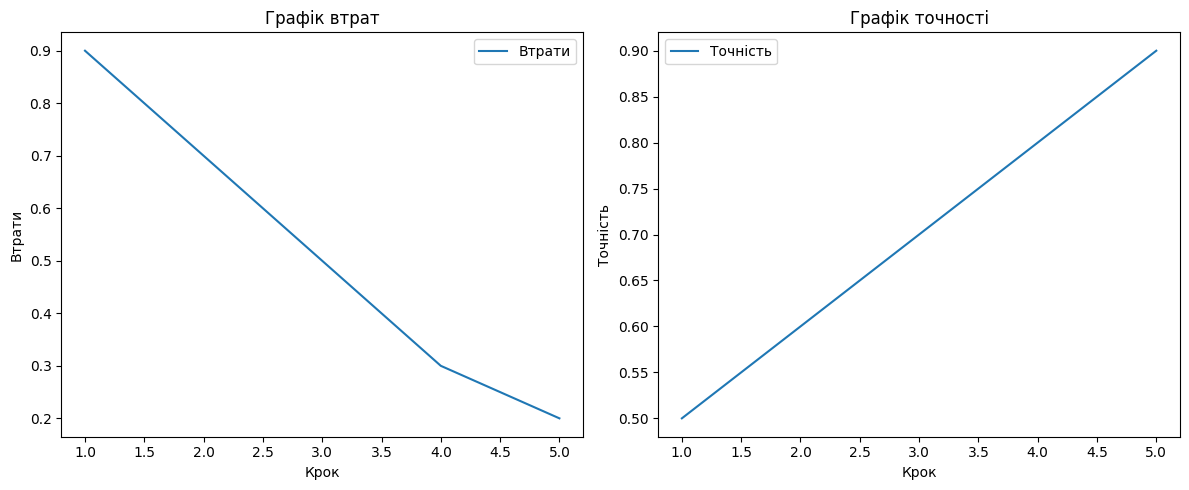

In [10]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

# Припустимо, що loss_history і accuracy_history містять відповідні дані
loss_history = [0.9, 0.7, 0.5, 0.3, 0.2]  # Приклад даних для втрат
accuracy_history = [0.5, 0.6, 0.7, 0.8, 0.9]  # Приклад даних для точності
steps = range(1, len(loss_history) + 1)  # Кроки

# Виведення графіка функції втрат
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(steps, loss_history, label="Втрати")
plt.title("Графік втрат")
plt.xlabel("Крок")
plt.ylabel("Втрати")
plt.legend()

# Виведення графіка точності
plt.subplot(1, 2, 2)
plt.plot(steps, accuracy_history, label="Точність")
plt.title("Графік точності")
plt.xlabel("Крок")
plt.ylabel("Точність")
plt.legend()

plt.tight_layout()
plt.show()


In [11]:
# Отримання передбачень для тестового набору даних
test_predictions = neural_net(x_test)

# Обчислення точності
test_accuracy = accuracy(test_predictions, y_test)

print(f"Точність на тестових даних: {test_accuracy.numpy()}")

Точність на тестових даних: 0.902899980545044


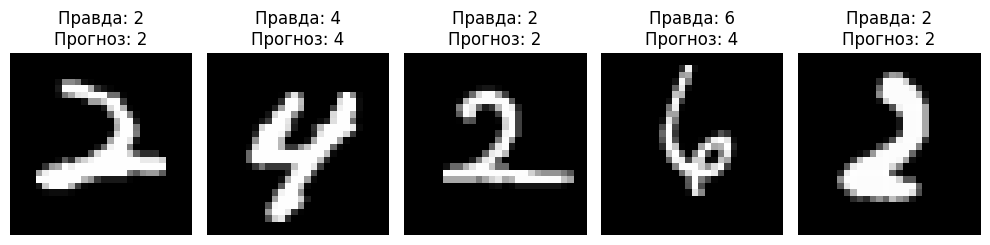

In [13]:
random_indices = np.random.choice(x_test.shape[0], 5, replace=False)
sample_images = x_test[random_indices]
sample_labels = y_test[random_indices]

sample_predictions = neural_net(sample_images)
predicted_classes = np.argmax(sample_predictions, axis=1)

plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(sample_images[i].reshape(28, 28), cmap='gray')
    plt.title(f"Правда: {sample_labels[i]}\nПрогноз: {predicted_classes[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()
#Модель працює точно